<a href="https://colab.research.google.com/github/rfr27/QA-Inicio/blob/main/radiografias1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 103.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 121.9 MB/s eta 0:00:00


In [62]:
#load all libraries
import requests
import json
import torch
import torch.nn as nn
import os
from tqdm import tqdm
from transformers import BertModel, BertTokenizerFast, AdamW, AutoTokenizer, AutoModelForQuestionAnswering, BertTokenizer, BertForQuestionAnswering
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

In [3]:
MODEL_PATH = "bert-base-uncased"

#Cargar dataset

In [4]:
#get SQuAD v2
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
!wget -nc https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2023-06-05 22:01:49--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.110.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M  --.-KB/s    in 0.1s    

2023-06-05 22:01:52 (287 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2023-06-05 22:01:52--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.111.153, 185.199.110.153, 185.199.109.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.111.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

In [18]:
num_questions = 0
num_posible = 0
num_imposible = 0

In [19]:
#seleccionar solo las que tienen respuesta
def get_data(path):  
    #read each file and retrieve the contexts, qustions and answers
  with open(path, 'rb') as f:
    raw_data = json.load(f)

  contexts = []
  questions = []
  answers = []
  num_q = 0
  num_pos = 0
  num_imp = 0

  for group in raw_data['data']:
    for paragraph in group['paragraphs']:
      context = paragraph['context']
      for qa in paragraph['qas']:
        question = qa['question']
        num_q  = num_q  +1
        if qa['is_impossible'] == True:
            num_imp = num_imp +1
        else:
            num_pos = num_pos +1
        for answer in qa['answers']:
          contexts.append(context.lower())
          questions.append(question.lower())
          answers.append(answer)

  return num_q, num_pos, num_imp, contexts, questions, answers

In [20]:
num_q, num_pos, num_imp, train_contexts, train_questions, train_answers = get_data('train.json')
num_questions  = num_q
num_posible = num_pos
num_imposible  = num_imp

In [21]:
print(train_questions[0:10])
print(train_answers[0:10])

['did the bleeding in the sub-dural space resolve?', 'did the bleeding in the sub-dural space resolve?', 'is there any significant change in bleeding?', 'does the small bowel look obstructed with complete block of contrast agent?', 'are there any contraindications for iv contrast?', 'are there any contraindications for iv contrast?', 'did the contrast show any changes in terms of its passage thorugh the small intestine?', 'does the small bowel look obstructed with complete block of contrast agent?', 'is there any significant change from prior visit?', 'how is the position of new defribillator different from the previous one?']
[{'answer_id': '796653_1_2_I_MG', 'text': 'Subdural hematomas with blood products of different ages', 'answer_start': 13}, {'answer_id': '796653_1_2_O_MG', 'text': 'mixed density subdural hematomas seen along both cerebral\n convexities, slightly larger on the left (approx 8-9mm) than on the right.\n There is acute blood in the dependent parts of the subdural col

In [22]:
num_q, num_pos, num_imp, valid_contexts, valid_questions, valid_answers = get_data('dev.json')
num_questions  = num_questions + num_q
num_posible = num_posible + num_pos
num_imposible = num_imposible  + num_imp

print(f"Total number of questions: {num_questions}")
print(f"Total number of Answerable questions: {num_posible}")
print(f"Total number of impossible questions: {num_imposible}")

Total number of questions: 5534
Total number of Answerable questions: 3934
Total number of impossible questions: 1600


In [23]:
print(valid_questions[0:10])
print(valid_answers[0:10])

["can the patient's shortness of breath be explained by any infiltrations in the lungs?", "can the patient's shortness of breath be explained by any infiltrations in the lungs?", 'is infil present?', 'is infil present?', "can the patient's shortness of breath be explained by any infiltrations in the lungs?", "can the patient's shortness of breath be explained by any infiltrations in the lungs?", 'is infil present?', 'is infil present?', 'did the gastric cancer metastasize to chest?', 'does the pelvis show any findings of gastric cancer metastasis?']
[{'answer_id': '1053165_1_1_I_MG', 'text': 'Right mid lung opacity is concerning for early pneumonia', 'answer_start': 13}, {'answer_id': '1053165_1_1_I_SS', 'text': 'Right mid lung opacity is concerning for early pneumonia', 'answer_start': 13}, {'answer_id': '1053165_2_1_I_MG', 'text': 'Right mid lung opacity', 'answer_start': 13}, {'answer_id': '1053165_2_1_I_SS', 'text': 'Right mid lung opacity', 'answer_start': 13}, {'answer_id': '1053

In [24]:
def add_answer_end(answers, contexts):
  for answer, context in zip(answers, contexts):
    answer['text'] = answer['text'].lower()
    answer['answer_end'] = answer['answer_start'] + len(answer['text'])

add_answer_end(train_answers, train_contexts)
add_answer_end(valid_answers, valid_contexts)

In [25]:
print(f"Context: {train_contexts[0]}")
print(f"Question: {train_questions[0]}")
print(f"Answer: {train_answers[0]}")

Context: impression:  subdural hematomas with blood products of different ages.
 question vescular abnormality in left suprasellar space.  findings were
 discussed with dr. [**last name (stitle) 8620**] at 9:25 am on [**2191-8-5**].  an mri of the brain and mra
 of the cow is recommended.
Question: did the bleeding in the sub-dural space resolve?
Answer: {'answer_id': '796653_1_2_I_MG', 'text': 'subdural hematomas with blood products of different ages', 'answer_start': 13, 'answer_end': 69}


In [26]:
test_rec = 30
print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Answer: {valid_answers[test_rec]}")

Context: conclusion: mild, non-significant plaque in bilateral carotid bulbs,
 associated with luminal narrowing less than 40% in diameter on each side.
 absence of significant carotid artery stenosis.
Question: is there any obstruction found within the carotid arteries?
Answer: {'answer_id': '834281_2_1_I_MG', 'text': 'mild, non-significant plaque in bilateral carotid bulbs,\n associated with luminal narrowing less than 40% in diameter on each side.\n absence of significant carotid artery stenosis', 'answer_start': 12, 'answer_end': 191}


#Tokenizar

Encontrar la máxima longitud

2077


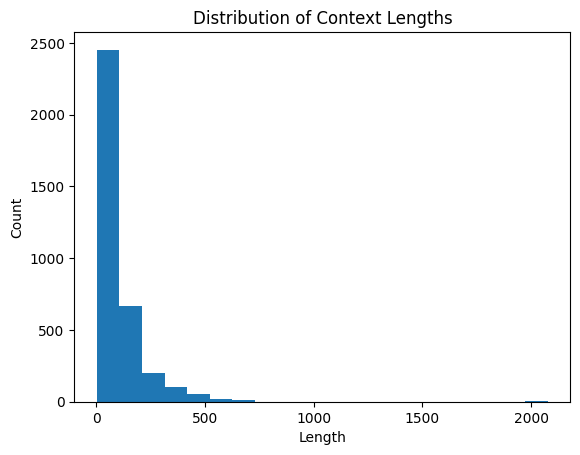

In [27]:
#Longitud de textos CONTEXTO 
token_lens = []

for txt in train_contexts:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens.append(len(txt.split(' ')))
  

print(max(token_lens))

plt.hist(token_lens,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Context Lengths');

18
3509


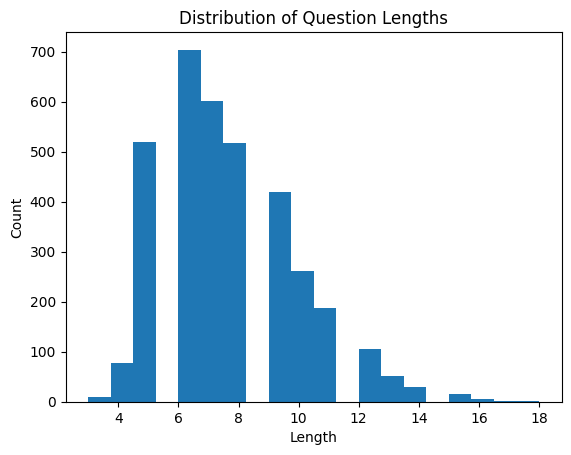

In [28]:
##Longitud de textos PREGUNTAS 
token_lens2 = []

for txt in train_questions:
    txt = txt.strip()  # remove leading and trailing whitespaces
    token_lens2.append(len(txt.split(' ')))


print(max(token_lens2))
print(len(token_lens2))

plt.hist(token_lens2,  bins=20)  # density=False would make counts
plt.ylabel('Count')
plt.xlabel('Length')
plt.title('Distribution of Question Lengths');

In [29]:
MAX_LENGTH = 500  

tokenizar

In [30]:
tokenizerFast = BertTokenizerFast.from_pretrained(MODEL_PATH)

train_encodings_fast = tokenizerFast(train_questions, train_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)
valid_encodings_fast = tokenizerFast(valid_questions,valid_contexts,  max_length = MAX_LENGTH, truncation=True, padding=True)

In [31]:
type(train_encodings_fast)

transformers.tokenization_utils_base.BatchEncoding

In [32]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['input_ids'][0]))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
3509
500


In [33]:
print(train_encodings_fast['input_ids'][0])

[101, 2106, 1996, 9524, 1999, 1996, 4942, 1011, 4241, 7941, 2686, 10663, 1029, 102, 8605, 1024, 4942, 24979, 2389, 19610, 10610, 9335, 2007, 2668, 3688, 1997, 2367, 5535, 1012, 3160, 2310, 28817, 8017, 19470, 3012, 1999, 2187, 10514, 18098, 11022, 17305, 2686, 1012, 9556, 2020, 6936, 2007, 2852, 1012, 1031, 1008, 1008, 2197, 2171, 1006, 2358, 4183, 2571, 1007, 6564, 11387, 1008, 1008, 1033, 2012, 1023, 1024, 2423, 2572, 2006, 1031, 1008, 1008, 20636, 2487, 1011, 1022, 1011, 1019, 1008, 1008, 1033, 1012, 2019, 27011, 1997, 1996, 4167, 1998, 2720, 2050, 1997, 1996, 11190, 2003, 6749, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [34]:
type(train_answers[0]['text'])
train_answers[0].keys()

dict_keys(['answer_id', 'text', 'answer_start', 'answer_end'])

In [ ]:
#train_answer_encodings_fast = tokenizerFast(train_answers[0]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)


In [35]:
def ret_Answer_start_and_end_train(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(train_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(train_encodings_fast['input_ids'][idx]) -  len(answer_encoding_fast['input_ids']) ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            
            if (answer_encoding_fast['input_ids'][i] != train_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [36]:
test_rec=92

z,x = ret_Answer_start_and_end_train(test_rec)
print(z, x)

predict_answer_tokens = train_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

11 14
no definite pneumonia
no definite pneumonia
[CLS] are there any lung infiltrates? [SEP] impression : no definite pneumonia. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [37]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
3509


In [38]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(train_encodings_fast['input_ids'])):
    #print(h)
    s, e = ret_Answer_start_and_end_train(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
train_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

93


In [39]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
3509


In [40]:
test_rec = 1
print(train_encodings_fast['start_positions'][test_rec])
print(train_encodings_fast['end_positions'][test_rec])
predict_answer_tokens = train_encodings_fast.input_ids[test_rec][train_encodings_fast['start_positions'][test_rec] : train_encodings_fast['end_positions'][test_rec]]
print(tokenizerFast.decode(predict_answer_tokens))
print(train_answers[test_rec]['text'])
print(tokenizerFast.decode(train_encodings_fast['input_ids'][test_rec]))

253
299
mixed density subdural hematomas seen along both cerebral convexities, slightly larger on the left ( approx 8 - 9mm ) than on the right. there is acute blood in the dependent parts of the subdural collections
mixed density subdural hematomas seen along both cerebral
 convexities, slightly larger on the left (approx 8-9mm) than on the right.
 there is acute blood in the dependent parts of the subdural collections
[CLS] did the bleeding in the sub - dural space resolve? [SEP] wet read : mes fri [ * * 2191 - 8 - 5 * * ] 1 : 40 am no significant change in hemorrhage _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ final report indication : known subarachnoid subdural hemorrhage from outside hospital. evaluate for any change. technique : noncontrast head ct. comparison : ( ct done several hours earlier at [ * * hospital 539 * * ] hospital ). at the time of attending review, the

In [43]:
def ret_Answer_start_and_end_valid(idx):
    ret_start = 0
    ret_end = 0
    answer_encoding_fast = tokenizerFast(valid_answers[idx]['text'],  max_length = MAX_LENGTH, truncation=True, padding=True)
    for a in range( len(valid_encodings_fast['input_ids'][idx])  -  len(answer_encoding_fast['input_ids'])   ): #len(train_encodings_fast['input_ids'][0])):
        match = True
        for i in range(1,len(answer_encoding_fast['input_ids']) - 1):
            if (answer_encoding_fast['input_ids'][i] != valid_encodings_fast['input_ids'][idx][a + i]):
                match = False
                break
        if match:
            ret_start = a+1
            ret_end = a+i+1
            break
    return(ret_start, ret_end)

In [44]:
start_positions = []
end_positions = []
ctr = 0
for h in range(len(valid_encodings_fast['input_ids']) ):
    #print(h)
    s, e = ret_Answer_start_and_end_valid(h)
    start_positions.append(s)
    end_positions.append(e)
    if s==0:
        ctr = ctr + 1

    
valid_encodings_fast.update({'start_positions': start_positions, 'end_positions': end_positions})
print(ctr)

4


In [45]:
test_rec=2

z,x = ret_Answer_start_and_end_valid(test_rec)

predict_answer_tokens = valid_encodings_fast.input_ids[test_rec][z : x]
print(tokenizerFast.decode(predict_answer_tokens))
print(valid_answers[test_rec]['text'])
print(tokenizerFast.decode(valid_encodings_fast['input_ids'][test_rec]))

right mid lung opacity
right mid lung opacity
[CLS] is infil present? [SEP] impression : right mid lung opacity is concerning for early pneumonia. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [46]:
print(train_encodings_fast.keys())
print(valid_encodings_fast.keys())
print(len(train_encodings_fast['input_ids']))
print(len(train_encodings_fast['start_positions']))
print(len(train_encodings_fast['end_positions']))
print(len(valid_encodings_fast['input_ids']))
print(len(valid_encodings_fast['start_positions']))
print(len(valid_encodings_fast['end_positions']))

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])
3509
3509
3509
632
632
632


In [48]:
tokenizerFast.decode(train_encodings_fast['input_ids'][0])

'[CLS] did the bleeding in the sub - dural space resolve? [SEP] impression : subdural hematomas with blood products of different ages. question vescular abnormality in left suprasellar space. findings were discussed with dr. [ * * last name ( stitle ) 8620 * * ] at 9 : 25 am on [ * * 2191 - 8 - 5 * * ]. an mri of the brain and mra of the cow is recommended. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [49]:
test_row= 0
print(train_contexts[test_row][train_answers[test_row]['answer_start']:train_answers[test_row]['answer_end']])


subdural hematomas with blood products of different ages


In [53]:
print('answer_start')

answer_start


In [59]:
answer_start_index = 16
answer_end_index = 28

predict_answer_tokens = train_encodings_fast.input_ids[0][answer_start_index : answer_end_index]
tokenizerFast.decode(predict_answer_tokens)

'subdural hematomas with blood products of different ages'

# Probar modelo pre-entrenado
esto no me sale

In [73]:
question= train_questions[0]
text = train_contexts[0]

print(question)
print(text)

did the bleeding in the sub-dural space resolve?
impression:  subdural hematomas with blood products of different ages.
 question vescular abnormality in left suprasellar space.  findings were
 discussed with dr. [**last name (stitle) 8620**] at 9:25 am on [**2191-8-5**].  an mri of the brain and mra
 of the cow is recommended.


In [74]:
inputs = tokenizer2(question, text, return_tensors="pt")
with torch.no_grad():
    outputs = model2(**inputs)

In [75]:
answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()
print(answer_start_index)
print(answer_end_index)

tensor(0)
tensor(0)


In [78]:
predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer2.decode(predict_answer_tokens)

'[CLS]'

#Crear Dataset y Dataloaders

In [79]:
class InputDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, i):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][i]),
            'token_type_ids': torch.tensor(self.encodings['token_type_ids'][i]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][i]),
            'start_positions': torch.tensor(self.encodings['start_positions'][i]),
            'end_positions': torch.tensor(self.encodings['end_positions'][i])
        }
    def __len__(self):
        return len(self.encodings['input_ids'])

In [80]:
train_dataset = InputDataset(train_encodings_fast)
valid_dataset = InputDataset(valid_encodings_fast)

In [81]:
print(len(train_dataset))
print(train_dataset[0].keys())

3509
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'])


In [82]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32)

#crear el modelo

In [87]:
bert_model = BertModel.from_pretrained(MODEL_PATH)  #MODEL_PATH = "bert-base-uncased"

class QAModel(nn.Module):
    def __init__(self):
        super(QAModel, self).__init__()
        self.bert = bert_model
        self.drop_out = nn.Dropout(0.1)
        self.l1 = nn.Linear(768 * 2, 768 * 2)
        self.l2 = nn.Linear(768 * 2, 2)
        self.linear_relu_stack = nn.Sequential(
            self.drop_out,
            self.l1,
            nn.LeakyReLU(),
            self.l2 
        )
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        model_output = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, output_hidden_states=True)
        hidden_states = model_output[2]
        out = torch.cat((hidden_states[-1], hidden_states[-3]), dim=-1)  # taking Start logits from last BERT layer, End Logits from third to last layer
        logits = self.linear_relu_stack(out)
        
        start_logits, end_logits = logits.split(1, dim=-1)
        
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [88]:
model = QAModel()

In [89]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


#Crear la funcion de perdidas

In [90]:
# my function to manually calculate Cross Entropy Loss
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)/2
    return total_loss

In [91]:
# my focal loss function. Focal Loss = (True Vector)*((1 - probs)^Gamma)*log(probs)
# where Gamma is a factor we use. setting Gamma = 0 makes this a Cross Entropy Loss function

def focal_loss_fn(start_logits, end_logits, start_positions, end_positions, gamma):
    
    #calculate Probabilities by applying Softmax to the Start and End Logits. Then get 1 - probabilities
    smax = nn.Softmax(dim=1)
    probs_start = smax(start_logits)
    inv_probs_start = 1 - probs_start
    probs_end = smax(end_logits)
    inv_probs_end = 1 - probs_end
    
    #get log of probabilities. Note: NLLLoss required log probabilities. This is the Natural Log (Log base e)
    lsmax = nn.LogSoftmax(dim=1)
    log_probs_start = lsmax(start_logits)
    log_probs_end = lsmax(end_logits)
    
    nll = nn.NLLLoss()
    
    fl_start = nll(torch.pow(inv_probs_start, gamma)* log_probs_start, start_positions)
    fl_end = nll(torch.pow(inv_probs_end, gamma)*log_probs_end, end_positions)
    
    #return mean of the Loss for the start and end logits
    return ((fl_start + fl_end)/2)

Probar en un input

In [ ]:
#data = next(iter(train_data_loader))
#data.keys()

In [ ]:
#print(data['input_ids'].shape)
#print(data['attention_mask'].shape)

In [ ]:
#run one row
#model.to(device)
#model.train()
#input_ids = data['input_ids'][0].unsqueeze(0).to(device)
#attention_mask = data['attention_mask'][0].unsqueeze(0).to(device)
#start_positions = data['start_positions'][0].unsqueeze(0).to(device)
#end_positions = data['end_positions'][0].unsqueeze(0).to(device)

In [ ]:
#out_start, out_end = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)


In [ ]:
#print(f"start logits shape: {out_start.shape}")
#print(f"end logits shape: {out_end.shape}")

In [ ]:
#answer_start_index = out_start.argmax()
#answer_end_index = out_end.argmax()
#print(answer_start_index)
#print(answer_end_index)

# Train loop

In [92]:
optim = AdamW(model.parameters(), lr=2e-5, weight_decay=2e-2)
scheduler = ExponentialLR(optim, gamma=0.9)
total_acc = []
total_loss = []

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [93]:
def train_epoch(model, dataloader, epoch):
    model = model.train()
    losses = []
    acc = []
    ctr = 0
    batch_tracker = 0
    for batch in tqdm(dataloader, desc = 'Running Epoch '):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        out_start, out_end = model(input_ids=input_ids, 
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
        #loss = loss_fn(out_start, out_end, start_positions, end_positions)  # <---BASELINE.  Cross Entropy Loss is returned by Default
        loss = focal_loss_fn(out_start, out_end, start_positions, end_positions,1) #using gamma = 1
        losses.append(loss.item())
        loss.backward()
        optim.step()
        
        start_pred = torch.argmax(out_start, dim=1)
        end_pred = torch.argmax(out_end, dim=1)
            
        acc.append(((start_pred == start_positions).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_positions).sum()/len(end_pred)).item())
        #ctr = ctr +1
        #if ctr==50:
        #    break
        batch_tracker = batch_tracker + 1
        if batch_tracker==250 and epoch==1:
            total_acc.append(sum(acc)/len(acc))
            loss_avg = sum(losses)/len(losses)
            total_loss.append(loss_avg)
            batch_tracker = 0
    scheduler.step()
    ret_acc = sum(acc)/len(acc)
    ret_loss = sum(losses)/len(losses)
    return(ret_acc, ret_loss)

In [94]:
def eval_model(model, dataloader):
    model = model.eval()
    losses = []
    acc = []
    ctr = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc = 'Running Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            start_true = batch['start_positions'].to(device)
            end_true = batch['end_positions'].to(device)
            
            out_start, out_end = model(input_ids=input_ids, 
                attention_mask=attention_mask,
                token_type_ids=token_type_ids)
            
            start_pred = torch.argmax(out_start, dim=1)
            end_pred = torch.argmax(out_end, dim=1)
            
            acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
            acc.append(((end_pred == end_true).sum()/len(end_pred)).item())
            #ctr = ctr +1
            #if ctr==50:
            #    break
        ret_acc = sum(acc)/len(acc)
        ret_loss = 0
        #ret_loss = sum(losses)/len(losses)
    return(ret_acc)

In [95]:
EPOCHS = 4

model.to(device)

for epoch in range(EPOCHS):
    train_acc, train_loss = train_epoch(model, train_data_loader, epoch+1)
    print(f"Train Accuracy: {train_acc}      Train Loss: {train_loss}")
    val_acc = eval_model(model, valid_data_loader)
    print(f"Validation Accuracy: {val_acc}")
    
#val_acc, val_loss = eval_model(model, valid_data_loader)
#print(f"Validation Accuracy: {val_acc}   Validation Loss: {val_loss}")
  

Running Epoch : 100%|██████████| 220/220 [05:33<00:00,  1.52s/it]


Train Accuracy: 0.34536931826309725      Train Loss: 2.272865557128733


Running Evaluation: 100%|██████████| 20/20 [00:22<00:00,  1.10s/it]


Validation Accuracy: 0.527083333581686


Running Epoch : 100%|██████████| 220/220 [05:38<00:00,  1.54s/it]


Train Accuracy: 0.5596022727814588      Train Loss: 1.1853288609873165


Running Evaluation: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]


Validation Accuracy: 0.5880208343267441


Running Epoch : 100%|██████████| 220/220 [05:38<00:00,  1.54s/it]


Train Accuracy: 0.6656250000677325      Train Loss: 0.8231025947765871


Running Evaluation: 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Validation Accuracy: 0.5687500007450581


Running Epoch : 100%|██████████| 220/220 [05:38<00:00,  1.54s/it]


Train Accuracy: 0.7465340909632769      Train Loss: 0.5765613537620414


Running Evaluation: 100%|██████████| 20/20 [00:21<00:00,  1.10s/it]

Validation Accuracy: 0.5703125


In [96]:
scheduler.get_last_lr()

[1.3122e-05]

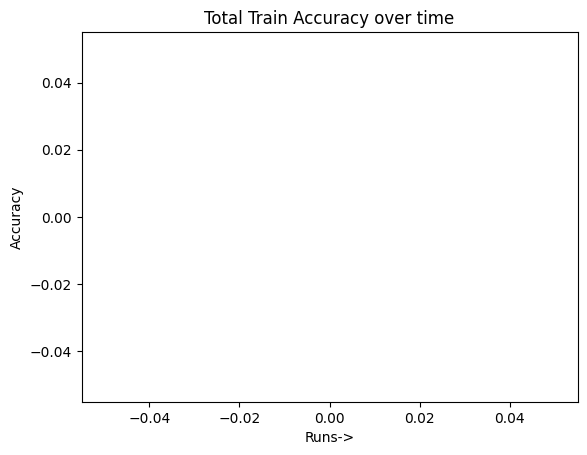

In [97]:
# plot Accuracy
plt.plot(total_acc, color='blue')
plt.ylabel('Accuracy')
plt.xlabel('Runs->')
plt.title("Total Train Accuracy over time");

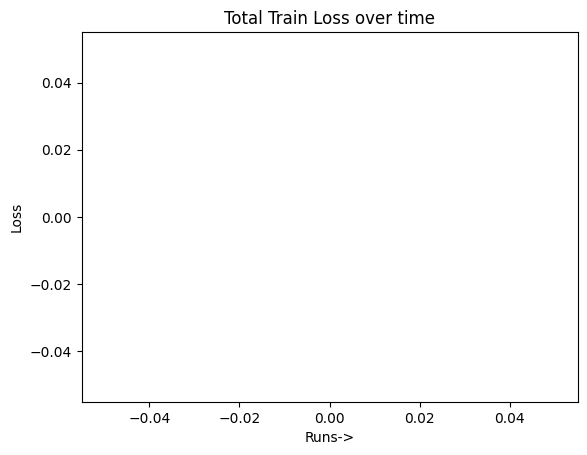

In [98]:
# plot Loss
plt.plot(total_loss, color='red')
plt.ylabel('Loss')
plt.xlabel('Runs->')
plt.title("Total Train Loss over time");

In [117]:
torch.save(model.state_dict(), 'best_model_state.bin')

# Test

In [100]:
def get_answer(question, context):
    inputs = tokenizerFast.encode_plus(question, context, return_tensors='pt').to(device)
    with torch.no_grad():
        output_start, output_end = model(**inputs)
        
        answer_start = torch.argmax(output_start)  
        answer_end = torch.argmax(output_end) 

        answer = tokenizerFast.convert_tokens_to_string(tokenizerFast.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))

        return(answer)

In [101]:
test_rec = 0

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: impression:  right mid lung opacity is concerning for early pneumonia.
Question: can the patient's shortness of breath be explained by any infiltrations in the lungs?
Expected Answer: {'answer_id': '1053165_1_1_I_MG', 'text': 'right mid lung opacity is concerning for early pneumonia', 'answer_start': 13, 'answer_end': 69}
Predicted Answer: right mid lung opacity


In [114]:
test_rec = 25

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: final report
 history:  a 62-year-old female with pain and swelling of the right calf.

 comparison:  [**2109-7-28**].

 findings:  grayscale and color doppler son[**name (ni) 98**] of the right common femoral,
 superficial femoral, and popliteal veins were obtained.  there is normal
 compressibility, flow, and augmentation without evidence of dvt.  compression
 was demonstrated within the superficial calf veins, without evidence of
 thrombus.
Question: is edema caused by dvt?
Expected Answer: {'answer_id': '1082671_2_1_O_SS', 'text': 'without evidence of dvt', 'answer_start': 326, 'answer_end': 349}
Predicted Answer: normal compressibility, flow, and augmentation without evidence of dvt


In [ ]:
test_rec =50

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

In [108]:
test_rec = 100

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: final report
 indication: right cerebellar intraparenchymal bleed with mass effect. compare
 with prior.

 technique: noncontrast head ct.

 findings: there is no significant change in the size of the right cerebellar
 hemorrhage.  there is a thin rim of low attenuation consistent with edematous
 change.  there is mass effect on the 4th ventricle.  the 4th ventricle is
 patent, though narrowed. the right cerebellar tonsil projects into the foramen
 magnum.  the basilar cisterns and ventricles are patent. again demonstrated is
 extensive periventricular low attenuation consistent with chronic
 microvascular disease. the sulcal pattern is prominent consistent with
 atrophic change.

 the osseous structures and visualized paranasal sinuses are unremarkable.
Question: has cerebeller hemorrhage progressed?
Expected Answer: {'answer_id': '803976_2_1_O_SS', 'text': 'no significant change in the size', 'answer_start': 160, 'answer_end': 193}
Predicted Answer: no significant change in 

In [109]:
test_rec = 500

print(f"Context: {valid_contexts[test_rec]}")
print(f"Question: {valid_questions[test_rec]}")
print(f"Expected Answer: {valid_answers[test_rec]}")

context = valid_contexts[test_rec]
question = valid_questions[test_rec]

print(f"Predicted Answer: {get_answer(question, context)}")

Context: impression:  no evidence for chf or pneumonia or other significant
 abnormality.
Question: did you find evidence of cardiomegaly?
Expected Answer: {'answer_id': '741952_2_1_I_MG', 'text': 'no evidence for chf', 'answer_start': 13, 'answer_end': 32}
Predicted Answer: no evidence for chf or pneumonia or other significant abnormality
